In [1]:
import pandas as pd
import numpy as np

import os
import sys

In [2]:
df = pd.read_csv(r"tweet_emotions.csv")

In [3]:
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [4]:
import nltk
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams

nltk.download('words')
from nltk.corpus import words
  
correct_words = words.words()


def spelling_fix(text):
    new_text = []
    incorrect_words = nltk.word_tokenize(text)
    for word in incorrect_words:
        temp = [(jaccard_distance(set(ngrams(word, 2)),
                                  set(ngrams(w, 2))),w)
                for w in correct_words if w[0]==word[0]]
        most_similar_list = sorted(temp, key = lambda val:val[0])
        
        if len(most_similar_list) == 0:
            new_text.append(word)
            continue
            
        if most_similar_list[0][0] >= 0.9:
            new_text.append(most_similar_list[0][1])
        else:
            new_text.append(word)
            
    return " ".join(new_text)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def remove_emoji(text):
    regex_pattern = re.compile("["                               
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U0001F1E6-\U0001F1FF"                                
                               "]+", flags=re.UNICODE)

    return regex_pattern.sub(r'', text)


def remove_email(text):
    return re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})', '', text)
def remove_repeated_char(text):
    return re.sub(r'(.)\1\1{1,}', r'\1\1', text)


def remove_account_tag(text):
    return re.sub(r'@[\w]+', '', text)


def remove_hashtag(text):
    return re.sub(r'#[\w]+', '', text)


def remove_links(text):
    return re.sub(r'http[^\s]+', '', text)


def remove_spaces(text):
    text = re.sub(r"\d+", ' ', text)
    text = re.sub(r"\n+", ' ', text)
    text = re.sub(r"\t+", ' ', text)
    text = re.sub(r"\r+", ' ', text)
    text = re.sub(r"\s+", ' ', text)
    return text
def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    return " ".join([w for w in word_tokens if not w in stop_words])


def remove_less_2_characters(text):
    return re.sub(r"\W*\b\w{1,2}\b", '', text)


def lemmatize(text):
    new_text = []
    tokenization = nltk.word_tokenize(text)
    for w in tokenization:
        tmp_w = wordnet_lemmatizer.lemmatize(w)
        if tmp_w is None:
            new_text.append(w)
        else:
            new_text.append(tmp_w)
    return " ".join(new_text)
def preprocess_text_sample(text):
    text = remove_emoji(text)
    text = remove_email(text)
    text = remove_repeated_char(text)
    text = remove_account_tag(text)
    text = remove_hashtag(text)
    text = remove_links(text)
    text = remove_stop_words(text)
    text = remove_spaces(text)
    text = remove_less_2_characters(text)
    text = text.strip()
    text = text.lower()
    #text = spelling_fix(text)
    text = lemmatize(text)
    return text


def preprocess_text_cols(df, col):
    df[col] = df[col].apply(lambda x: preprocess_text_sample(x))
    return df

def preprocess_df(df, col="content"):
    df = preprocess_text_cols(df, col)
    df.dropna(inplace=True)
    return df

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
df = preprocess_df(df, "content")
df = df[df["content"] != ""]

In [8]:
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,know listenin bad habit earlier started freaki...
1,1956967666,sadness,layin bed headache ughh .. waitin call ..
2,1956967696,sadness,funeral ceremony .. gloomy friday ..
3,1956967789,enthusiasm,want hang friend soon !
4,1956968416,neutral,"want trade someone houston ticket , one ."


In [9]:
df['sentiment'].value_counts()

neutral       8531
worry         8444
happiness     5205
sadness       5158
love          3839
surprise      2183
fun           1776
relief        1525
hate          1322
empty          810
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

C:\Users\sanja\anaconda3\envs\ml_everything\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

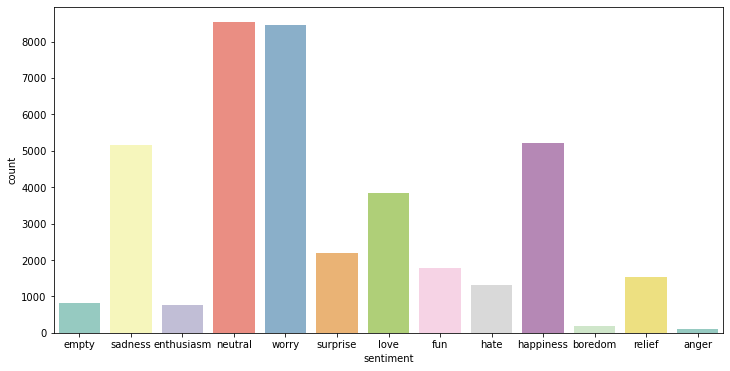

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12,6))
sns.countplot(df["sentiment"], palette='Set3')

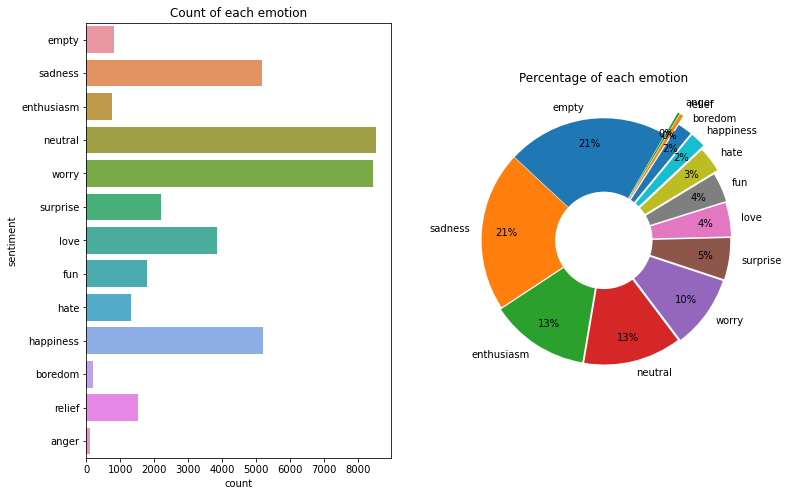

In [11]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df["sentiment"].dropna().value_counts()))/sum(list(df["sentiment"].dropna().value_counts())))[::-1])[:]
labels = list(df["sentiment"].dropna().unique())[:]
sizes = df["sentiment"].value_counts()[:]

ax2.pie(sizes,  explode=explode, startangle=60, labels=labels, autopct='%1.0f%%', pctdistance=0.8)
ax2.add_artist(plt.Circle((0,0),0.4,fc='white'))
sns.countplot(y="sentiment", data=df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

In [12]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder


def get_label_encoder_obj(y):
    label_encoder = LabelEncoder()
    return label_encoder.fit(y)


def get_y_label_encoder(label_encoder, y):
    return label_encoder.transform(y)


def get_label_decoder(label_encoder, y):
    return label_encoder.classes_[y]


def one_hot_encode(y, num_classes):
    return to_categorical(y, num_classes=num_classes)

Using TensorFlow backend.


In [13]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.1, random_state=2, stratify=df["sentiment"])

In [14]:
label_encoder = get_label_encoder_obj(train["sentiment"])
train["sentiment"] = get_y_label_encoder(label_encoder, train["sentiment"])
val["sentiment"] = get_y_label_encoder(label_encoder, val["sentiment"])

C:\Users\sanja\AppData\Local\Temp\ipykernel_28244\4108910125.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["sentiment"] = get_y_label_encoder(label_encoder, train["sentiment"])
C:\Users\sanja\AppData\Local\Temp\ipykernel_28244\4108910125.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val["sentiment"] = get_y_label_encoder(label_encoder, val["sentiment"])


In [48]:
label_encoder.classes_

array(['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness',
       'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise',
       'worry'], dtype=object)

In [15]:
num_classes = len(np.unique(train["sentiment"]))
num_classes

13

In [16]:
X_train = train["content"].values
y_train = train["sentiment"].values
X_val = val["content"].values
y_val = val["sentiment"].values

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

def CountVectorizer_fit(X_train, ngram_range=(1,1)):
    count_vect = CountVectorizer(ngram_range=ngram_range)
    return count_vect.fit(X_train)


def CountVectorizer_transform(count_vect, X):
    return count_vect.transform(X)

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import f1_score as f1_score_rep
import seaborn as sn


def print_score(y_pred, y_real, label_encoder):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print("Precision:: ", precision_score(y_real, y_pred, average="micro"))
    print("Recall:: ", recall_score(y_real, y_pred, average="micro"))
    print("F1_Score:: ", f1_score_rep(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (macro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="macro"))

    print()
    print("Macro precision_recall_fscore_support (micro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (weighted) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="weighted"))
    print()
    print("Confusion Matrix")
    cm = confusion_matrix(y_real, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = [i for i in label_encoder.classes_],
                  columns = [i for i in label_encoder.classes_])
    plt.figure(figsize = (20,20))
    sn.heatmap(df_cm, annot=True)

    print()
    print("Classification Report")
    print(classification_report(y_real, y_pred, target_names=label_encoder.classes_))

In [19]:
count_vect = CountVectorizer_fit(X_train, ngram_range=(1,3))
X_train_counts = CountVectorizer_transform(count_vect, X_train)
X_val_counts = CountVectorizer_transform(count_vect, X_val)

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer


def TfidfTransformer_fit(X_train_counts, use_idf=True):
    tf_transformer = TfidfTransformer(use_idf=use_idf)
    return tf_transformer.fit(X_train_counts)


def TfidfTransformer_transform(tf_transformer, X_counts):
    return tf_transformer.transform(X_counts)

In [21]:
tf_transformer = TfidfTransformer_fit(X_train_counts)
X_train_tfidf = TfidfTransformer_transform(tf_transformer, X_train_counts)
X_val_tfidf = TfidfTransformer_transform(tf_transformer, X_val_counts)

In [22]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
import nltk

nltk.download('punkt')
nltk.download('wordnet')

oov_tok = "<oov_tok>"

def count_vectorizer(corpus):
    vectorizer = CountVectorizer(analyzer='word')
    corpus_words = vectorizer.fit_transform(corpus)
    return len(vectorizer.vocabulary_)


def get_tokenizer_obj(text_list, num_words):
    tokenizer = Tokenizer(lower=True, split=" ", num_words=num_words, oov_token=oov_tok)
    tokenizer.fit_on_texts(text_list)
    return tokenizer, len(tokenizer.word_index)


def tokenize_texts_to_sequences(tokenizer, text_list):
     return tokenizer.texts_to_sequences(text_list)
    
def padding_sequences(x_arr, max_len):
    x_arr = pad_sequences(x_arr, maxlen=max_len, value=0, padding='post')
    return x_arr 


def get_num_words(df, col):
    return count_vectorizer(df[col])


def get_max_statment_len(df, col):
    return max([len(text.split()) for text in df[col]])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
col = "content"
num_words = get_num_words(train, col)
max_statment_len = get_max_statment_len(train, col)
tokenizer, vocab_size = get_tokenizer_obj(train[col].values, num_words)
X_train = tokenize_texts_to_sequences(tokenizer, train[col].values)
X_train = padding_sequences(X_train, max_statment_len)

In [24]:
X_val = tokenize_texts_to_sequences(tokenizer, val[col].values)
X_val = padding_sequences(X_val, max_statment_len)

In [25]:
X_val.shape

(3985, 46)

In [26]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

In [27]:
from sklearn.utils import class_weight

def get_class_weights(y):
    class_weights = class_weight.compute_class_weight('balanced',
                                                      classes=np.unique(y),
                                                      y=y)
    return {k: v for k, v in enumerate(class_weights)}

In [28]:
y_train = one_hot_encode(train["sentiment"], num_classes)
y_val = one_hot_encode(val["sentiment"], num_classes)

In [29]:
y_train.shape

(35856, 13)

In [30]:
import tensorflow as tf
import keras.backend as K


def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [31]:
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Input, Dropout, Conv1D, Reshape, Permute, Lambda
from keras.layers import RepeatVector, Flatten, multiply, Dropout
from keras.models import Model
from keras.metrics import Recall, Precision
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from os.path import join
import time

In [32]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [33]:
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, TIME_STEPS):
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) 
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul


In [34]:
def build_model(MAX_NB_WORDS,
                MAX_TEXT_LEN,
                nb_classes,
                learning_rate=2e-5,
                epsilon=1e-08):
    EMBEDDING_DIM = 100
    inputs = Input(name='inputs',shape=[MAX_TEXT_LEN])
    layer = Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length=MAX_TEXT_LEN)(inputs)
    lstm_units = 64
    lstm_out = LSTM(lstm_units, return_sequences=True)(layer)
    attention_mul = attention_3d_block(lstm_out, MAX_TEXT_LEN)
    attention_mul = Flatten()(attention_mul)
    output = Dense(nb_classes, activation='softmax')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate,epsilon=epsilon),
                  loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), f1_score])
    print(model.summary())
    return model

In [35]:
def train_model(model, X_train, y_train, X_val, y_val,
                #class_weights,
                weights_dir,
                epochs=20,
                mini_batch_size=32,
                ):
    model_weights_file_path = join(weights_dir, "custom_model_weights.h5")
    checkpoint = ModelCheckpoint(filepath=model_weights_file_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max", save_weights_only=True)
    early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=5)
    plotlosses = PlotLossesKeras()
    call_backs = [checkpoint, early_stopping, plotlosses]
    start_time = time.time()

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=mini_batch_size,
                        callbacks=call_backs,
                        #class_weight=class_weights,
                        verbose=1)

    duration = time.time() - start_time
    print("Model take {} S to train ".format(duration))
    return model, history

def predict(model, X_test):
    return model.predict(X_test)

In [36]:
max_text_length = X_train.shape[1]
model = build_model(vocab_size,                    
                    max_text_length,
                    num_classes,
                    learning_rate=0.001)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 46)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 46, 100)      2389700     inputs[0][0]                     
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 46, 64)       42240       embedding[0][0]                  
__________________________________________________________________________________________________
permute (Permute)               (None, 64, 46)       0           lstm[0][0]                       
______________________________________________________________________________________________

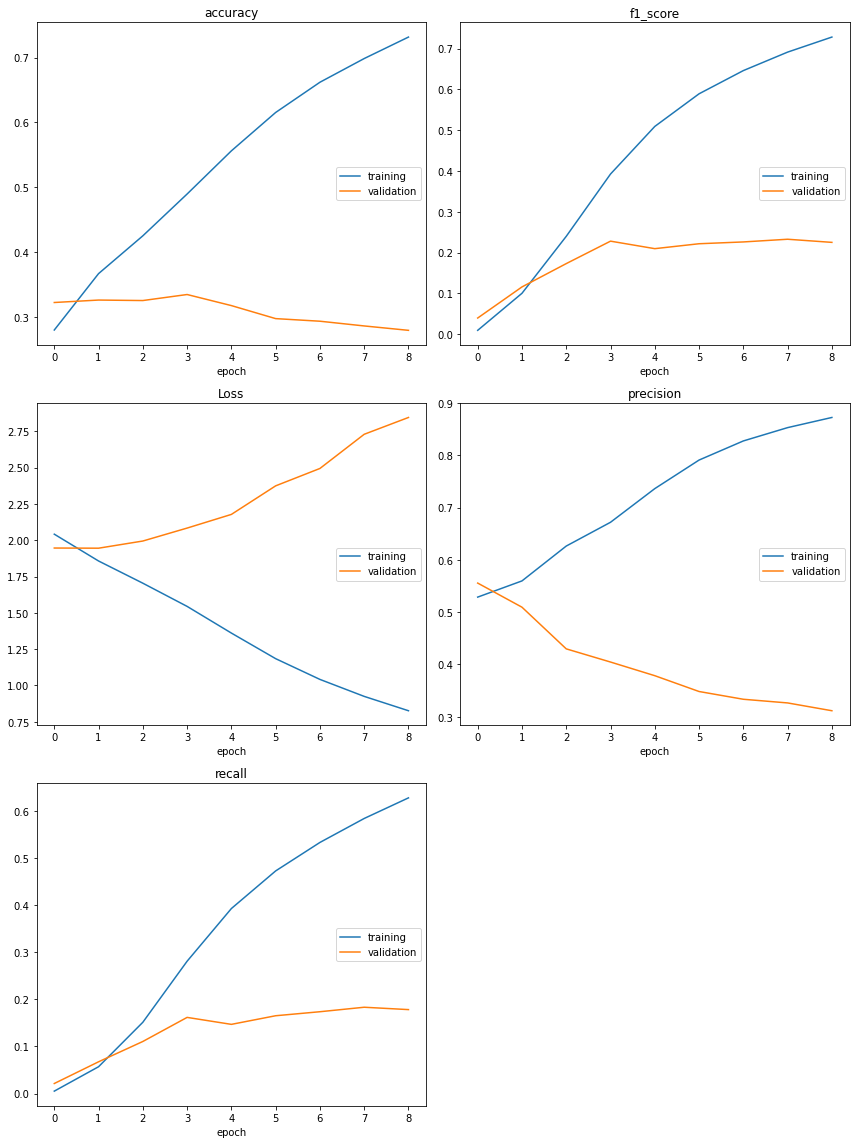

accuracy
	training         	 (min:    0.280, max:    0.732, cur:    0.732)
	validation       	 (min:    0.280, max:    0.335, cur:    0.280)
f1_score
	training         	 (min:    0.010, max:    0.728, cur:    0.728)
	validation       	 (min:    0.040, max:    0.233, cur:    0.225)
Loss
	training         	 (min:    0.826, max:    2.042, cur:    0.826)
	validation       	 (min:    1.945, max:    2.845, cur:    2.845)
precision
	training         	 (min:    0.529, max:    0.872, cur:    0.872)
	validation       	 (min:    0.312, max:    0.556, cur:    0.312)
recall
	training         	 (min:    0.005, max:    0.628, cur:    0.628)
	validation       	 (min:    0.021, max:    0.183, cur:    0.178)
Epoch 00009: early stopping
Model take 360.26561546325684 S to train 


(<tensorflow.python.keras.engine.functional.Functional at 0x2d65ad7cb50>,
 <tensorflow.python.keras.callbacks.History at 0x2d65aca2e20>)

In [37]:
weights_path = ""
train_model(model, X_train, y_train, 
            X_val, y_val,
            #class_weights,
            weights_path)

In [38]:
model.load_weights("./custom_model_weights.h5")

In [39]:
y_hat = model.predict(X_val)

Accuracy:  0.33475533249686323
Precision::  0.33475533249686323
Recall::  0.33475533249686323
F1_Score::  0.33475533249686323

Macro precision_recall_fscore_support (macro) average
(0.1901545217568367, 0.1679714266554203, 0.16089738660593975, None)

Macro precision_recall_fscore_support (micro) average
(0.33475533249686323, 0.33475533249686323, 0.33475533249686323, None)

Macro precision_recall_fscore_support (weighted) average
(0.29770796279900946, 0.33475533249686323, 0.29764550691105973, None)

Confusion Matrix

Classification Report
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        11
     boredom       0.00      0.00      0.00        18
       empty       0.00      0.00      0.00        81
  enthusiasm       0.00      0.00      0.00        76
         fun       0.10      0.04      0.06       178
   happiness       0.30      0.48      0.37       521
        hate       0.55      0.12      0.20       132
        love       0.48 

C:\Users\sanja\anaconda3\envs\ml_everything\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanja\anaconda3\envs\ml_everything\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanja\anaconda3\envs\ml_everything\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

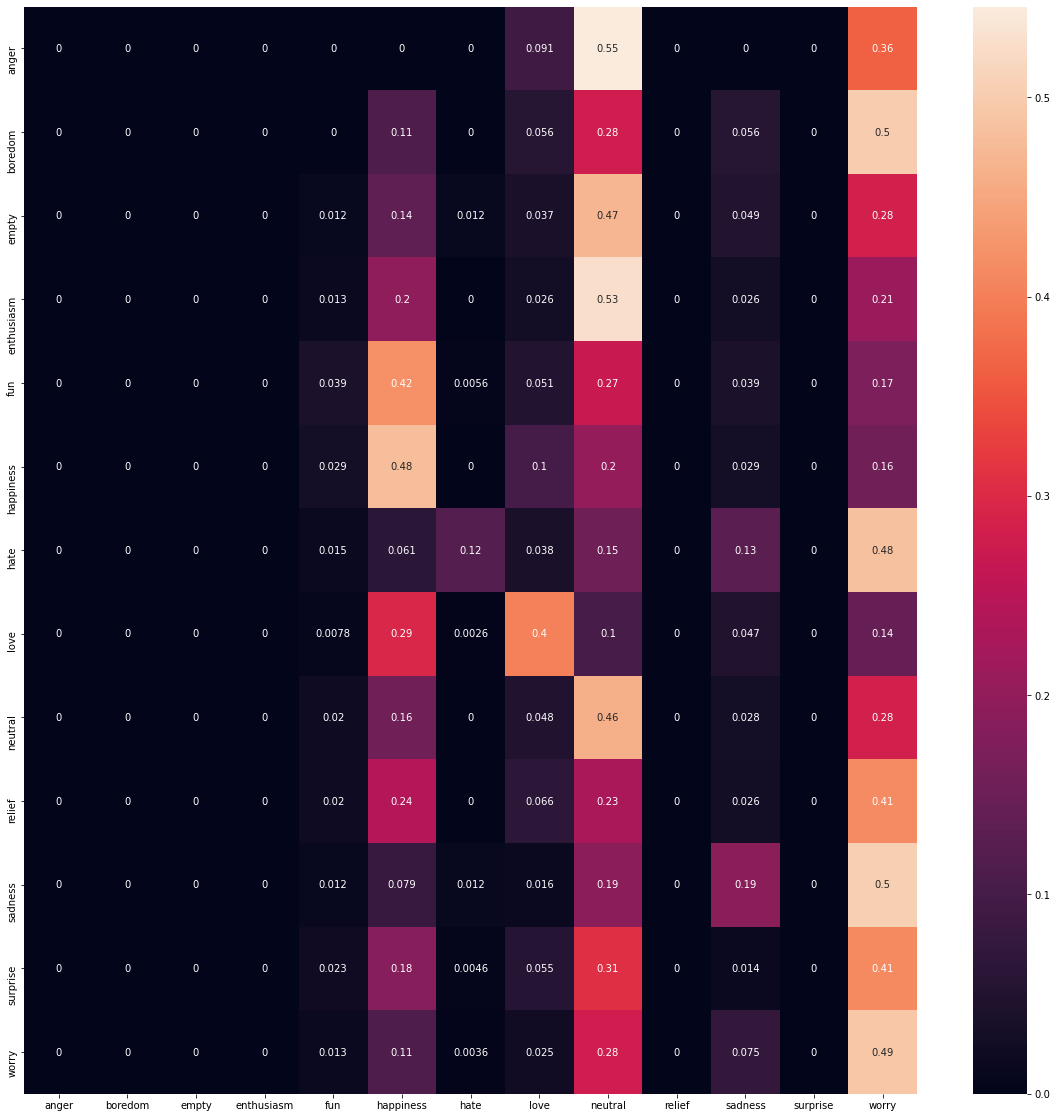

In [40]:
y_pred = np.argmax(y_hat, axis=1)
y_real = np.argmax(y_val, axis=1)
print_score(y_pred, y_real, label_encoder)

In [41]:
model_text_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_text_json)
# serialize weights to HDF5
model.save_weights("text_model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [42]:
X_val[0].shape

(46,)

In [44]:
max_statment_len = get_max_statment_len(train, col)

In [45]:
max_statment_len

46